# Generative Adversarial Networks(GAN) Examples(MNIST data)

References : https://www.youtube.com/watch?v=AVvlDmhHgC4&t=2033s

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/package'
save_path = '/content/drive/MyDrive/Colab Notebooks/package' ## 패키지가 저장될 경로

os.symlink(save_path, my_path) ## 심볼릭 링크 사용
sys.path.insert(0, my_path)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn # for Generator, Discriminator achitecture definition

from torchvision import datasets # for MNIST(손으로 쓴 숫자들로 이루어진 대형 DB)
import torchvision.transforms as transforms # 의도한 방향으로 변형을 가해 전처리하기 위함
from torchvision.utils import save_image # 학습 진행 과정에서 반복적으로 생성된 이미지를 출력하기 위함

In [3]:
latent_dim = 100 # latent vector를 뽑기 위한 "noise 분포"의 dimension.
# 분포는 해당 코드에서는 통상적인 Gaussian distribution 사용(Uniform 가능)

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # __init__ 내 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize = True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행 (차원은 동일함)
                layers.append(nn.BatchNorm1d(output_dim, 0.8)) # 1d : 1차원 입력에 대해서만 정규화 수행 / momentum = 0.8(이전 배치의 평균과 분산 값 반영 정도)
            layers.append(nn.LeakyReLU(0.2, inplace = True)) # Activation Function으로 LeakyReLU 사용
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가진다.
        self.model = nn.Sequential( # nn.Linear, nn.ReLU(Activation Function) 등의 모듈을 인수로 받아 순서대로 정렬, 실행. 신경망의 깊이 깊어질수록 좋음.
            *block(latent_dim, 128, normalize = False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28), # 결과적으로 1 x 28 x 28짜리 하나의 MNIST 이미지 데이터 생성.
            nn.Tanh() # Hyperbolic Tangent 함수를 통과시켜 (-1, 1) 값 도출함. Activation Function의 일종
        )

    def forward(self, z): # z : noise vector. / forward() 에서는 모델에서 실행돼야 하는 연산을 정의. (backward 계산은 backward() 메소드)
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28) # view(batch size, channel, height, width)
        return img # Ensure that the forward method returns the generated image

In [4]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512), # 한 장의 이미지 들어왔을 때 이를 판별하기 위함
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 1),
            nn.Sigmoid() # Activation Function으로 Sigmoid 사용하여 확률 값(0 ~ 1)을 내보내도록 함. 다중 분류 아니므로 Softmax 사용하지 않음
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1) # flatten해서 하나의 vector(행벡터) 형태로 나타냄.
        output = self.model(flattened)
        return output

# 학습 데이터셋 불러오기



*   학습을 위해 MNIST 데이터셋을 불러옵니다.





In [5]:
transforms_train = transforms.Compose([
    transforms.Resize(28), # 28 x 28로 이미지 사이즈 변형(Linear Transformation)
    transforms.ToTensor(), # PyTorch tensor로 변환
    transforms.Normalize([0.5], [0.5]) # 정규화
])

train_dataset = datasets.MNIST(root = "./dataset", train = True, download = True, transform = transforms_train) # 위에서 정의한 transforms_train 함수를 이용하여 이미지 변형
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 4) # 하나의 batch에 128개의 이미지 포함됨.


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16458217.13it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 503138.78it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4542499.17it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3608054.69it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 모델 학습 및 샘플링
*   학습을 위해 생성자와 판별자 모델 초기화
*   적절한 Hyperparameter 설정



In [6]:
# 생성자와 판별자 초기화
generator = Generator()
discriminator = Discriminator()
generator.cuda()
discriminator.cuda() # G, D를 GPU(NVIDIA T4)에 올림

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss().cuda() # Binary Cross Entropy Loss(0 / 1 분류 문제이므로. CrossEntropyLoss() 대신 사용) + loss function을 GPU에 올림

# Learning Rate 설정
lr = 0.0002

# 생성자와 판별자를 위한 Optimizer(Adam사용)
optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999)) # 일반적인 하이퍼파라미터 값임
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))

모델 학습하면서 주기적으로 샘플링하여 결과 이미지를 기록할 수 있도록 함.

In [7]:
import time

n_epochs = 200 # 총 Epoch 값 설정

sample_interval = 2000 # 몇 번의 batch마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜 이미지와 가짜 이미지에 대한 정답 label 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real) : 1.0(float)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake) : 0.0(float)

        real_imgs = imgs.cuda()

        # --- 생성자(Generator) 학습 시작 (원 논문과 학습 순서 변경, 진행상황 확인 필요) ---
        optimizer_G.zero_grad()

        # Random noise sampling
        z = torch.normal(mean = 0, std = 1, size = (imgs.shape[0], latent_dim)).cuda() # z는 noise vector. / imgs.shape[0] : 이미지의 개수 인덱싱

        # Image generation
        generated_imgs = generator(z)

        # Calculate Generator's loss
        g_loss = adversarial_loss(discriminator(generated_imgs), real) # 생성자 입장에서, 판별자가 real로 판별할 만한 이미지를 생성해 내는 방향으로 학습

        # Update Generator
        g_loss.backward() # backpropagation(automated), 모든 연결 체인에 대해 그라디언트를 계산하는 루틴
        optimizer_G.step()

        # --- 판별자(Discriminator) 학습 시작 ---
        optimizer_D.zero_grad()

        # Calculate Discriminator's loss
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake) # detach() : Gradient의 "forward" propagation을 중지시킴. 분리된 Tensor 리턴
        d_loss = (real_loss + fake_loss) / 2 # Discriminator의 loss 값은 real/fake loss의 평균치

        # Update Discriminator
        d_loss.backward() # backpropagation(automated), 모든 연결 체인에 대해 그라디언트를 계산하는 루틴
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중 25개만 선택하여 5 x 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow = 5, normalize = True)

    # 하나의 epoch이 끝날 때마다 로그 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss : {d_loss.item():.6f}] [G loss : {g_loss.item():.6f}] [Elapsed time : {time.time() - start_time:.2f}s]")



<ipython-input-7-393da5f5babd>:12: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real) : 1.0(float)


[Epoch 0/200] [D loss : 0.582545] [G loss : 0.485662] [Elapsed time : 22.92s]
[Epoch 1/200] [D loss : 0.322901] [G loss : 2.248553] [Elapsed time : 41.01s]
[Epoch 2/200] [D loss : 0.305856] [G loss : 1.439634] [Elapsed time : 59.22s]
[Epoch 3/200] [D loss : 0.318177] [G loss : 1.059590] [Elapsed time : 75.89s]
[Epoch 4/200] [D loss : 0.341811] [G loss : 1.840855] [Elapsed time : 92.79s]
[Epoch 5/200] [D loss : 0.461104] [G loss : 0.692646] [Elapsed time : 110.68s]
[Epoch 6/200] [D loss : 0.375813] [G loss : 0.919713] [Elapsed time : 126.27s]
[Epoch 7/200] [D loss : 0.259981] [G loss : 1.203230] [Elapsed time : 142.19s]
[Epoch 8/200] [D loss : 0.253324] [G loss : 1.226797] [Elapsed time : 158.16s]
[Epoch 9/200] [D loss : 0.220752] [G loss : 1.445834] [Elapsed time : 174.48s]
[Epoch 10/200] [D loss : 0.598983] [G loss : 5.041257] [Elapsed time : 190.77s]
[Epoch 11/200] [D loss : 0.433303] [G loss : 0.807215] [Elapsed time : 206.79s]
[Epoch 12/200] [D loss : 0.170560] [G loss : 2.076516] 

### 학습 결과
> -> # of Epochs : 200/200, Total Elapsed time : about 3200s.(53 min.)

> Epoch을 거듭하면서, D loss와 G loss는 일관적인 방향으로 감소하기 보다는, "서로 엎치락 뒤치락 증감"하며 Saddle Point로 학습이 이뤄짐. GAN의 의의를 잘 반영한 결과



### 생성된 이미지 예시 출력(실제 이미지가 아닌, GAN으로 학습된 AI가 생성한 이미지)



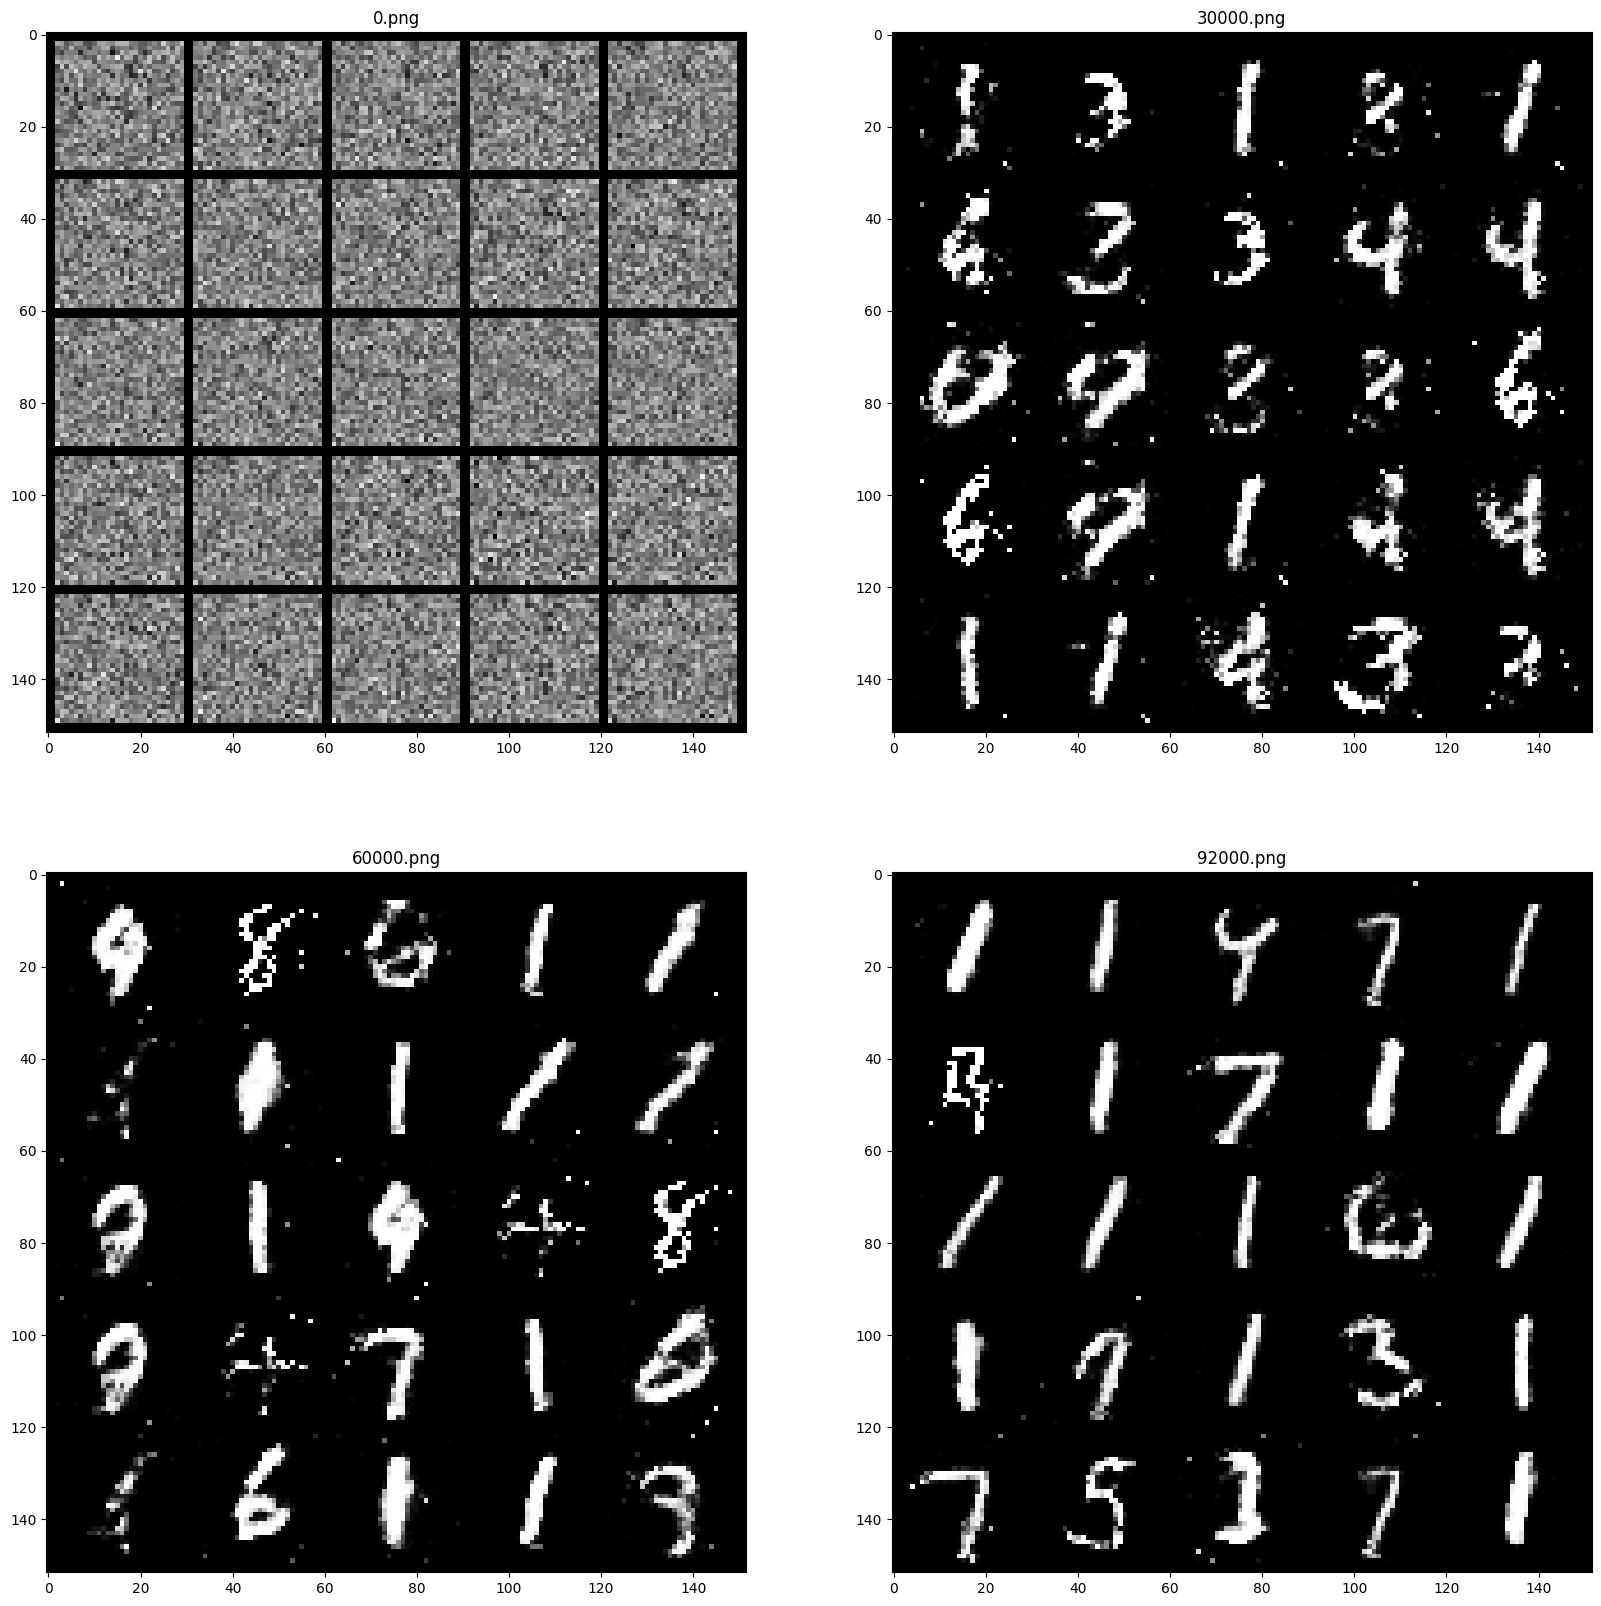

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

img1 = "0.png"
img2 = "30000.png"
img3 = "60000.png"
img4 = "92000.png"

img1 = Image.open(img1)
img2 = Image.open(img2)
img3 = Image.open(img3)
img4 = Image.open(img4)

plt.figure(figsize = (20, 20))
plt.subplot(2, 2, 1)
plt.title("0.png")
plt.imshow(img1)
plt.subplot(2, 2, 2)
plt.title("30000.png")
plt.imshow(img2)
plt.subplot(2, 2, 3)
plt.title("60000.png")
plt.imshow(img3)
plt.subplot(2, 2, 4)
plt.title("92000.png") # 가장 마지막으로 출력된 이미지
plt.imshow(img4)

plt.show()
